# Variable dz water balance

The purpose of this script is to be able to monitor a run's progress and view how the water balance is progressing (for example during spinup). It should take into consideration variable dz adjustments

In [2]:
from postproc import scale_pfb
import numpy as np

import subprocess
import glob
import os
import shutil
import time
import pandas as pd
from io import StringIO

%matplotlib inline

In [168]:
def silo2pfb(bnam, start, stop):
    '''
    Converts a timeseries of silo output to pfb format
    (saves converted pfbs to same directory)
    
    '''
    bashCommand = "tclsh silotopfb_iter_bnam.tcl %s %s %s" %(bnam,start,stop)
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    print(output)
    print(error)

def sumoverdomain(bnam, start, stop):
    '''
    Sums over the entire domain for an input pfb file,
    returns a dataframe with columns for t and the sum values
    
    bnam    the base name of the files to sum
    start   the start number of file indexing
    end     the end number of file indexing
    '''
    bashCommand = "tclsh sum_domain_bnam.tcl %s %s %s" %(bnam,start,stop)
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()

    # Save the output to a dataframe
    output = output.decode("utf-8").format()
    df = pd.read_csv(StringIO(output), sep="\t", header = None)
    df.columns = ['t','sum_val']  # add a header (column name)
    
    # return
    return(df)
    

# Apply scale factors for vdz

The scaling factors need to be applied for subsurface storage, and potentially to surface storage and surface runoff as well.

- Need a silotopfb_iter.tcl script that can be applied to various files' base names

In [135]:
factors = np.array([[10.0],  # <- bottom
                    [5.0],
                    [2.5],
                    [2.5],
                    [1.0],
                    [1.0],
                    [0.5],
                    [0.5],
                    [0.5],
                    [0.5]]) # <- top

## Overland Flow 
Overland flow does not need scale factors applied

In [178]:
silo2pfb(bnam ='surface_runoff' , start=1, stop=19)
of = sumoverdomain(bnam = 'surface_runoff',start = 1, stop= 19)
of.head(10)

b''
None


,t,sum_val
0,1,0.000000
1,2,0.000000
2,3,0.000000
3,4,0.000000
4,5,0.000000
5,6,215.303045
6,7,672.173800
7,8,672.254291
8,9,672.329042
9,10,672.401010


## Surface Storage 
Surface storage does not need scale factors applied

In [177]:
silo2pfb(bnam ='surface_storage' , start= 0, stop=19)
s = sumoverdomain(bnam = 'surface_storage',start = 0, stop= 19)
s.head(10)

b''
None


,t,sum_val
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
5,5,0.000000
6,6,7532.711702
7,7,14914.551502
8,8,14915.623055
9,9,14916.618157


## Subsurface storage

In [181]:
# convert silos to pfbs
silo2pfb(bnam ='subsurface_storage' , start= 0, stop=19)

# scale pfbs using factors
for i in range(0,20):
    infnam = 'subsurface_storage.%s.pfb' %i
    outfnam = 'vdz_subsurface_storage.%s.pfb' %i
    
    scale_pfb(pfbinfnam = infnam, vdzarr = factors, pfboutfnam = outfnam, 
         nx = 12, ny = 10, dx = 10, dy = 10, dz = 1)
    
ss = sumoverdomain(bnam = 'vdz_subsurface_storage',start = 0, stop= 19)
ss.head(10)

b''
None


,t,sum_val
0,0,6.356904e+06
1,1,6.416904e+06
2,2,6.476904e+06
3,3,6.536904e+06
4,4,6.596904e+06
5,5,6.656904e+06
6,6,6.709371e+06
7,7,6.754457e+06
8,8,6.799541e+06
9,9,6.844625e+06


# Water balance

**NOTE** This will not balance if the run was executed with overland flow keys on! Water will begin to be "lost" from the domain when overland flow occurs.

In [186]:
wb = ss.merge(of, on = 't', how = 'left').merge(s, on = 't', how = 'left')
wb.fillna(0, inplace=True)
wb.columns = ['t', 'vdz_subsurfstor', 'overland_flow', 'surf_stor']
wb['dom_tot'] = wb['vdz_subsurfstor'] +  wb['overland_flow'] +  wb['surf_stor'] 
wb

,t,vdz_subsurfstor,overland_flow,surf_stor,dom_tot
0,0,6.356904e+06,0.000000,0.000000,6.356904e+06
1,1,6.416904e+06,0.000000,0.000000,6.416904e+06
2,2,6.476904e+06,0.000000,0.000000,6.476904e+06
3,3,6.536904e+06,0.000000,0.000000,6.536904e+06
4,4,6.596904e+06,0.000000,0.000000,6.596904e+06
5,5,6.656904e+06,0.000000,0.000000,6.656904e+06
6,6,6.709371e+06,215.303045,7532.711702,6.717119e+06
7,7,6.754457e+06,672.173800,14914.551502,6.770044e+06
8,8,6.799541e+06,672.254291,14915.623055,6.815129e+06
9,9,6.844625e+06,672.329042,14916.618157,6.860214e+06


In [188]:
wb['dom_tot'].diff()

0              NaN
1     60000.000000
2     60000.000000
3     60000.000000
4     60000.000000
5     60000.000000
6     60215.303045
7     52924.159053
8     45085.528988
9     45084.451696
10    45083.453810
11    45082.493191
12    45081.567579
13    65101.814187
14    18385.314395
15      618.287712
16      529.050048
17      510.854031
18      496.866807
19      485.932028
Name: dom_tot, dtype: float64

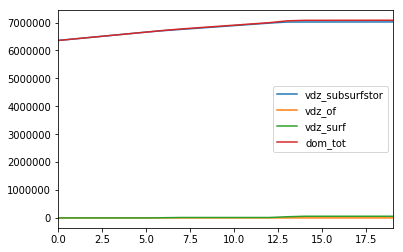

In [147]:
wb[['vdz_subsurfstor', 'vdz_of', 'vdz_surf', 'dom_tot']].plot.line()